This notebook provides some examples on how to interact programmatically with the `MFLike` likelihood.



## Preamble



In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cobaya
import camb
print("     Numpy :", np.__version__)
print("Matplotlib :", mpl.__version__)
print("      CAMB :", camb.__version__)
print("    Cobaya :", cobaya.__version__)

Numpy : 1.17.4
Matplotlib : 3.1.2
      CAMB : 1.0.10
    Cobaya : 2.1.0

## Loading & getting the MFLike likelihood from cobaya



We first set the default values of CMB and nuisance parameters



In [1]:
cosmo_params = {
    "cosmomc_theta": 0.0104085,
    "logA": {"value": 3.044, "drop": True},
    "As": {"value": "lambda logA: 1e-10*np.exp(logA)"},
    "ombh2": 0.02237,
    "omch2": 0.1200,
    "ns": 0.9649,
    "Alens": 1.0,
    "tau": 0.0544
}
nuisance_params= {
    "a_tSZ": 3.30,
    "a_kSZ": 1.60,
    "a_p": 6.90,
    "beta_p": 2.08,
    "a_c": 4.90,
    "beta_c": 2.20,
    "n_CIBC": 1.20,
    "a_s": 3.10,
    "T_d": 9.60
}

Then we declare our likelihood



In [1]:
mflike_config = {
    "mflike.MFLike": {"sim_id": 0, "select": "tt-te-ee"}
}

We will need to download and install [`LAT_MFLike_data`](https://github.com/simonsobs/LAT_MFLike_data). Here we will do it programatically in such a
way we can use this notebook without any prerequisites. Code and data will be stored in the `/tmp`
directory for the tutorial purpose but feel free to change it to whatever location you want. By the
way the next command will take some times to proceed



In [1]:
from cobaya.install import install
install({"likelihood": mflike_config}, path="/tmp/modules")

#+begin_example
[install] Installing modules at '/tmp/modules'

likelihood:mflike.MFLike

[mflike.MFLike] Downloading simonsobs/LAT_MFLike_data data...
[]
[mflike.MFLike] Downloaded filename /tmp/modules/data/LAT_MFLike_data-0.1.tar.gz
[mflike.MFLike] LAT_MFLike_data v0.1 downloaded and decompressed correctly.
[install] Successfully installed!

#+end_example

We finally put everything into a dictionary to push it into `cobaya` configuration system



In [1]:
info = {
    "params": {**cosmo_params, **nuisance_params},
    "likelihood": mflike_config,
    "theory": {"camb": None},
    "modules": "/tmp/modules"
}

We will now get the model given the above parameters



In [1]:
from cobaya.model import get_model
model = get_model(info)

To get a direct acces to the `MFLike` likelihood instance, we can retrieve it from the collection of
likelihoods of `cobaya` given its name (so far there is only our likelihood)



In [1]:
mflike = model.likelihood["mflike.MFLike"]

We can now play with the different data (Bbl, inverted covariance matrix) and we can also call the
different methods such as `_get_foreground_model` to see what foreground model look likes.



## Getting likelihood value given current parameter set



We can retrieve informations related to likelihood(s) as follow



In [1]:
loglikes, derived = model.loglikes({})
print("log-likelihood value = {}, derived parameter value (As) = {}".format(loglikes, derived))

log-likelihood value = [-774.78793554], derived parameter value (As) = [2.0989031673191437e-09]

We can also use the `evaluate` sampler that evaluates the log-likelihood at a given reference point :
here, since parameters are all fixed, it computes the log-likelihood value.



In [1]:
info["sampler"] = {"evaluate": None}
from cobaya.run import run
updated_info, products = run(info)

#+begin_example
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /tmp/modules/code/CAMB
[mflike.mflike] Initialising.
[model] The theory camb will compute the following products, requested by the likelihoods: ['Cl']
[evaluate] Initialized!
[evaluate] Looking for a reference point with non-zero prior.
[evaluate] Reference point:

[evaluate] Evaluating prior and likelihoods...
[evaluate] log-posterior  = -774.788
[evaluate] log-prior      = 0
[evaluate]    logprior_0 = 0
[evaluate] log-likelihood = -774.788
[evaluate]    chi2_mflike.MFLike = 1549.58
[evaluate] Derived params:
[evaluate]    As = 2.0989e-09
#+end_example

Finally, we can directly catch the value returned by `logp` function from `MFLike` likelihood



In [1]:
logp = mflike.logp(**nuisance_params)
print("log-likelihood value =", logp)
print("Χ² value =", -2*logp)

log-likelihood value = -774.7879355436245
Χ² value = 1549.575871087249

## Plotting CMB power spectra



Here we get $C_\ell$ for different mode and a different range of [&ell;<sub>min</sub>;&ell;<sub>max</sub>] than the
default range of `MFLike`. Make sure to call the `model.logposterior` line with the `cached=False`
option in order to recompute $C_\ell$s given the new &ell; range.



In [1]:
lmin, lmax = 2, 9000
Cl = {"tt": lmax, "ee": lmax, "te": lmax, "bb":lmax}
model.likelihood.theory.needs(Cl=Cl)
model.logposterior({}, cached=False)
Dls = model.likelihood.theory.get_Cl(ell_factor=True)

Let's plot the different spectra



# Out[10]:

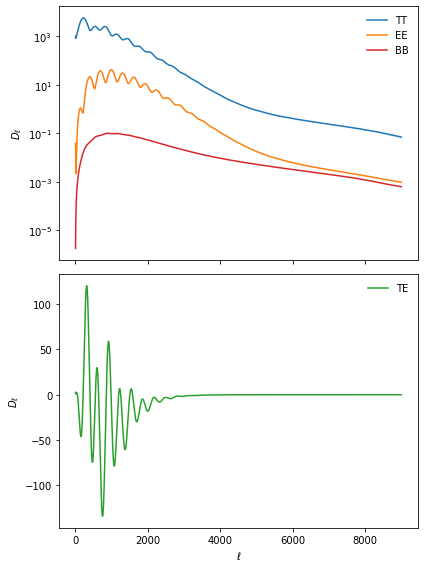

In [1]:
l = np.arange(lmin, lmax)
dls = {cl: Dls[cl][lmin:lmax] for cl in Cl.keys()}
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
axes[0].set_yscale("log")
for i, cl in enumerate(Cl.keys()):
    ax = axes[1] if cl == "te" else axes[0]
    ax.plot(l, dls[cl], "-C{}".format(i), label=cl.upper())

for ax in axes:
    ax.set_ylabel(r"$D_\ell$")
    ax.legend()
axes[1].set_xlabel(r"$\ell$")
plt.tight_layout()

## Plotting foregrounds



Get all the foreground models at higher &ell;



In [1]:
mflike.lmax = lmax
fg_models = mflike._get_foreground_model(nuisance_params)

Then plot them in a triangle plot



# Out[15]:

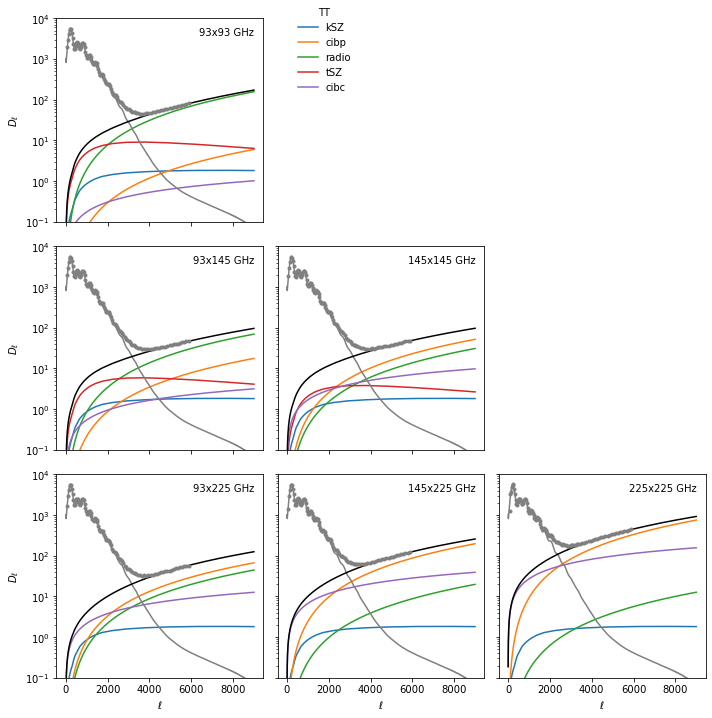

In [1]:
mode = "tt"
components = mflike.foregrounds["components"][mode]
for exp in mflike.experiments:
  freqs = list(*exp.values())
  nfreqs = len(freqs)
  fig, axes = plt.subplots(nfreqs, nfreqs, sharex=True, sharey=True, figsize=(10, 10))
  from itertools import product
  for i, cross in enumerate(product(freqs, freqs)):
    idx = (i%nfreqs, i//nfreqs)
    ax = axes[idx]
    if idx in zip(*np.triu_indices(nfreqs, k=1)):
      fig.delaxes(ax)
      continue
    for compo in components:
      ax.plot(l, fg_models[mode, compo, cross[0], cross[1]])
    ax.plot(l, dls[mode], color="gray")
    ax.plot(l, fg_models[mode, "all", cross[0], cross[1]], color="k")

    # Read SO data and plot on top
    fn = mflike.data_folder + "/Dl_LAT_{}xLAT_{}_{:05d}.dat".format(
      cross[0], cross[1], mflike.sim_id)
    ldata, ps = mflike._read_spectra(fn)
    ax.plot(ldata, ps[mode], ".", color="gray")

    ax.legend([], title="{}x{} GHz".format(*cross))
    if mode == "tt":
      ax.set_yscale("log")
      ax.set_ylim(10**-1, 10**4)

for i in range(nfreqs):
  axes[-1, i].set_xlabel("$\ell$")
  axes[i, 0].set_ylabel("$D_\ell$")
fig.legend(components, title=mode.upper(), bbox_to_anchor=(0.5,1))
plt.tight_layout()

We can also show the power spectra for all the simulations and compare its mean value to theory +
foregrounds



# Out[16]:

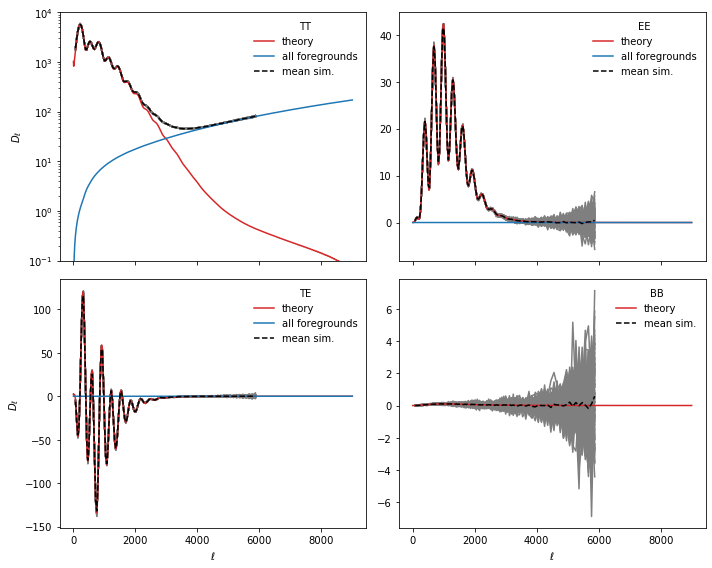

In [1]:
cross = (93, 93)
nsim = 100
tmpl = mflike.data_folder + "/Dl_LAT_{}xLAT_{}_{:05d}.dat"
data = [mflike._read_spectra(tmpl.format(*cross, sim_id)) for sim_id in range(nsim)]

ldata = data[0][0]
sims = {cl: [data[sim_id][1][cl] for sim_id in range(nsim)]
        for cl in Cl.keys()}

fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10, 8))
for cl, ax in zip(Cl.keys(), axes.flatten()):
    for ps in sims[cl]:
      ax.plot(ldata, ps, color="tab:gray")
    ax.plot(l, dls[cl], color="tab:red", label="theory")
    if cl != "bb":
        ax.plot(l, fg_models[cl, "all", cross[0], cross[1]],
                color="tab:blue", label="all foregrounds")
    ax.plot(ldata, np.mean(sims[cl], axis=0), "--k", label="mean sim.")
    ax.legend(title=cl.upper())
    if cl == "tt":
      ax.set_yscale("log")
      ax.set_ylim(10**-1, 10**4)

for ax in axes[:, 0]:
    ax.set_ylabel(r"$D_\ell$")
for ax in axes[-1]:
    ax.set_xlabel(r"$\ell$")
plt.tight_layout()

## Fisher matrix



Even if we do not need priors to compute Fisher matrix, we need to fool `cobaya` in order to change
parameter values. We need to take care of `logA` parameter since `cobaya` will sample it but theory
module will use the derivative `As` value.



In [1]:
sampled_params = {**cosmo_params, **nuisance_params}.copy()
sampled_params.update({k: {"prior": {"min": v, "max": v}}
                       for k, v in sampled_params.items() if k not in ["logA", "As"]})
sampled_params["logA"] = {"prior": {"min": cosmo_params["logA"]["value"],
                                    "max": cosmo_params["logA"]["value"]},
                          "drop": True}

Then we define a new model (after having close the previous one to release memory allocation) and
get the `MFLike` likelihood



In [1]:
if model: model.close()

info = {
    "params": sampled_params,
    "likelihood": mflike_config,
    "theory": {"camb": None},
    "modules": "/tmp/modules"
}
from cobaya.model import get_model
model = get_model(info)
mflike = model.likelihood["mflike.MFLike"]

Given the sampled parameters, we now set the defaults value of parameters in the same order as the
`cobaya`'s one



In [1]:
defaults = dict(zip(model.parameterization.sampled_params(),
                    model.prior.sample()[0]))

and we define the list of Fisher parameters



In [1]:
fisher_params = list(defaults.keys())
for p in ["tau", "n_CIBC", "T_d"]:
    fisher_params.remove(p)

For each parameter, we will compute the associated power spectra by slightly modifying the central
value of the parameter (&plusmn;&epsilon;). The power spectra is taken from `mflike._get_power_spectra`
given the nuisance parameters and we also need to recompute (if necessary) the theoritical
$C_\ell$s. The Fisher algorithm is then



In [1]:
deriv = {k: None for k in fisher_params}
for i, p in enumerate(deriv.keys()):
    def _get_power_spectra(epsilon):
        point = defaults.copy()
        point.update({p: point[p]*(1+epsilon)})
        model.logposterior(point)  # to force computation of theory
        cl = model.likelihood.theory.get_Cl(ell_factor=True)
        return mflike._get_power_spectra(cl, **point)
    epsilon = 0.01
    ps_minus = _get_power_spectra(-epsilon)
    ps_plus = _get_power_spectra(+epsilon)
    delta = (ps_plus - ps_minus)/(2*epsilon*defaults[p])
    if np.all(delta == 0):
        print("WARNING: Sampling a parameter '{}' that do not have "
              "any effect on power spectra! You should remove it from "
              "cobaya parameter dictionary.".format(p))
        fisher_params.remove(p)
        continue
    deriv[p] = delta

nparams = len(fisher_params)
fisher_matrix = np.empty((nparams, nparams))
for i1, p1 in enumerate(fisher_params):
    for i2, p2 in enumerate(fisher_params):
        fisher_matrix[i1, i2] = np.dot(deriv[p1], mflike.inv_cov.dot(deriv[p2]))
fisher_sigmas = np.sqrt(np.diag(np.linalg.inv(fisher_matrix)))
for param_name, param_sigma in zip(fisher_params, fisher_sigmas):
    print("param: {}, sigma: {}, Fisher S/N: {}".format(
        param_name, param_sigma, defaults[param_name]/param_sigma))

#+begin_example
param: cosmomc_theta, sigma: 1.4486065596974956e-06, Fisher S/N: 7185.180772737594
param: logA, sigma: 0.0036317591903408763, Fisher S/N: 838.1612988261732
param: ombh2, sigma: 6.536685600928835e-05, Fisher S/N: 342.2223641415662
param: omch2, sigma: 0.0011424383078940234, Fisher S/N: 105.03849456974933
param: ns, sigma: 0.0032727928987798167, Fisher S/N: 294.8246436124144
param: Alens, sigma: 0.022185732661698494, Fisher S/N: 45.074012891465266
param: a_tSZ, sigma: 0.0458633315121716, Fisher S/N: 71.95290641117552
param: a_kSZ, sigma: 0.10197033488608609, Fisher S/N: 15.690837946030134
param: a_p, sigma: 0.07612743384435548, Fisher S/N: 90.63749625538712
param: beta_p, sigma: 0.014099541556431264, Fisher S/N: 147.52252700381197
param: a_c, sigma: 0.12237773103807495, Fisher S/N: 40.03996444807006
param: beta_c, sigma: 0.031309839940458266, Fisher S/N: 70.26545022854562
param: a_s, sigma: 0.011254308374876228, Fisher S/N: 275.45006736445436
#+end_example

Let's show the Signal over Noise ratio graphically



# Out[75]:

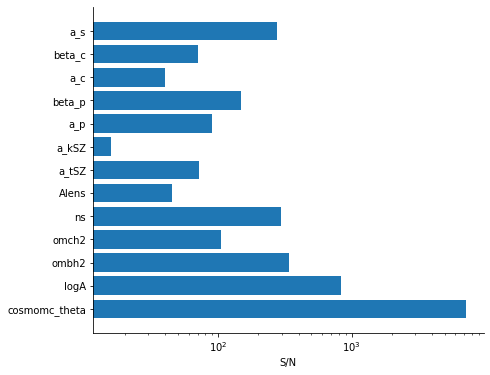

In [1]:
plt.figure(figsize=(7, 6))
SoN = [defaults[param_name]/param_sigma
       for param_name, param_sigma in zip(fisher_params, fisher_sigmas)]
plt.barh(np.arange(len(SoN)), SoN)
plt.xscale("log")
plt.xlabel("S/N")
plt.yticks(range(len(fisher_params)), fisher_params)
plt.gca().spines["right"].set_color(None)
plt.gca().spines["top"].set_color(None)

It also works for TT, TE or EE mode even if you keep the default list of sampled parameters. It will
only warn you about the fact that some parameters have no effect on power spectra and thus can be
removed from the sampled parameter list.



## Using the MFLike likelihood without cobaya



The `MFLike` likelihood can also be used independently of `cobaya`. The principle is the same as in
this `cobaya`'s [example](https://github.com/CobayaSampler/planck_lensing_external). First we need
to instantiate an `MFLike` object



In [1]:
from mflike import MFLike
my_mflike = MFLike({"path_install": r"/tmp/modules", "sim_id": 0})

To compute the log-likelihood value, we can use the `loglike` function which takes as parameters an
theoritical $C_\ell$ dictionary and the nuisance parameter values. The $C_\ell$ dictionary can be,
for instance, retrieved from an independant program or an independant computation. Here we will use
`CAMB` to compute the $C_\ell$ from a cosmological model set by the `cosmo_params`



In [1]:
camb_cosmo = {k: v for k, v in cosmo_params.items()
              if k not in ["logA", "As"]}
camb_cosmo.update({"As": 1e-10*np.exp(cosmo_params["logA"]["value"]),
                   "lmax": lmax, "lens_potential_accuracy": 1})

pars = camb.set_params(**camb_cosmo)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")
cl_dict = {k: powers["total"][:, v]
           for k, v in {"tt": 0, "ee": 1, "te": 3, "bb": 2}.items()}

Let's plot $C_\ell$



# Out[25]:

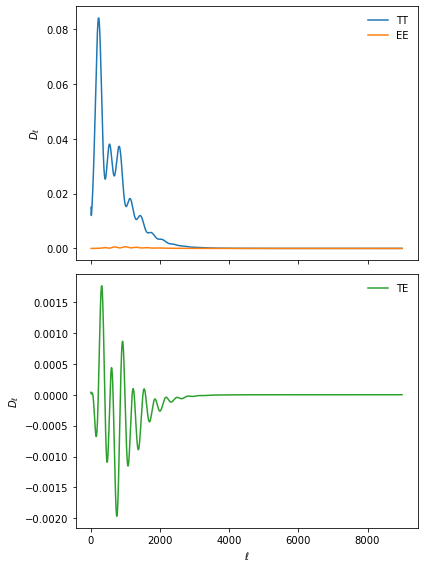

In [1]:
l = np.arange(cl_dict["tt"].shape[0])
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
axes[0].set_yscale("log")
for i, (k, v) in enumerate(cl_dict.items()):
    ax = axes[1] if k == "te" else axes[0]
    ax.plot(l, v, "-C{}".format(i), label=k.upper())

for ax in axes:
    ax.set_ylabel(r"$D_\ell$")
    ax.legend()
axes[1].set_xlabel(r"$\ell$")
plt.tight_layout()

Now we can inject these $C_\ell$ into the `loglike` function to get the corresponding log-likelihood
value



In [1]:
my_mflike.get_requirements()
loglike = my_mflike.loglike(cl_dict, **nuisance_params)
print("log-likelihood value =", loglike)
print("Χ² value =", -2*loglike)

log-likelihood value = -764.7226537443769
Χ² value = 1529.4453074887538

**N.B.**: log-likelihood value will be slightly different due to slightly different $C_\ell$ (see the
corresponding [issue](https://github.com/CobayaSampler/cobaya/issues/62) and the fix already done in `dependency` [branch](https://github.com/CobayaSampler/cobaya/commit/5bb411d4fa37096e019e5eeba637c52ca006a410#diff-5f7f811c43b0a5a021a3c87b95395359)).

